# Data wrangling WeRateDogs

##### By Pradeep Gurunathan

## Table of Contents
- [Introduction](#intro)
   - [Packages used](#package)
- [Gathering data](#gather)
- [Assessing data](#assess)
- [Cleaning data](#clean)
- [Store Data](#store_data)
- [Analyze Data](#analyze)

<a id='intro'></a>
## Introduction


The "We Rate Dogs" Twitter archive contains over 5000 tweets, which have been filtered to create the enhanced archive that forms the basis of this analysis. The purpose of this project is to data wrangling and then provide analyses and visualizations.

<a id='package'></a>
### Packages used

In [2]:
import pandas as pd
import numpy as np
import requests
import os
import tweepy
import json
import time
import datetime
import random

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

import seaborn as sns
sns.set(style="darkgrid")

# set the option to display the full string from a pandas DataFrame
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

<a id='gather'></a>
## Gathering data

### 1. Twitter archive file
Download this file manually by clicking the following link: twitter_archive_enhanced.csv

In [2]:
#Read Twitter archive CSV file 
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### 2. Tweet image predictions
This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [4]:
#Tweet image predictions URL downloaded programatically 
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

with open('image-predictions.tsv', mode ='wb') as file:
    file.write(response.content)

#Read TSV file
image_prediction = pd.read_csv('image-predictions.tsv', sep='\t' )

In [5]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### 3. Twitter API and JSON data to DataFrame
Extract the required fields from each tweet's JSON data and store in a separate file, tweet_data_extra.csv, for use during the assessment phase.

In [6]:
# Tweeter API
auth = tweepy.OAuthHandler('HIDDEN', 'HIDDEN')
auth.set_access_token('HIDDEN', 'HIDDEN')
api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

In [7]:
#Download Tweepy status object based on Tweet ID and store in list
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
cant_find_tweets_for_those_ids = []
for tweet_id in twitter_archive['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        cant_find_tweets_for_those_ids.append(tweet_id)

Rate limit reached. Sleeping for: 740
Rate limit reached. Sleeping for: 745


In [8]:
print("The list of tweets" ,len(list_of_tweets))
print("The list of tweets no found" , len(cant_find_tweets_for_those_ids))

The list of tweets 2331
The list of tweets no found 25


In [9]:
#Then in this code block we isolate the json part of each tweepy 
#status object that we have downloaded and we add them all into a list

my_list_of_dicts = []
for each_json_tweet in list_of_tweets:
    my_list_of_dicts.append(each_json_tweet)
    
#we write this list into a txt file:

with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(my_list_of_dicts, indent=4))

In [10]:
#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
my_demo_list = []
with open('tweet_json.txt', encoding='utf-8') as json_file:  
    all_data = json.load(json_file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_demo_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        tweet_json = pd.DataFrame(my_demo_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'retweeted_status', 'url'])


In [11]:
tweet_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35682,7546,8848762,17,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30864,5593,8848762,17,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,23199,3706,8848762,17,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38983,7727,8848762,17,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,37238,8326,8848762,17,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [12]:
df_tweet_data_extra = pd.DataFrame(tweet_json)

In [16]:
df_tweet_data_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null object
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null object
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


In [17]:
# store in a separate file, tweet_data_extra.csv
df_tweet_data_extra.to_csv('tweet_data_extra.csv', index = False)

<a id='assess'></a>
## Assessing Data

In this section data is assess that was gathered, both visually and programmatically for quality and tidiness issues. One of the key points for the analysis requires that only tweets with original ratings with images, no retweets, be retained.

The quality of data is assessed against dimensions or criteria concerning the content: completeness, validity, accuracy and consistency.

In [28]:
# Load the data gathered data files
archive_data = pd.read_csv('twitter-archive-enhanced.csv')
predictions_data = pd.read_csv('image-predictions.tsv', sep = '\\t', engine = 'python')
json_data = pd.read_csv('tweet_data_extra.csv')

### Assesing archive_data

In [3]:
archive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

---
**NOTES:**

The `info()` method reveals several quality and tidiness issues:

- **retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp** these fields having 181 retweets
- **in_reply_to_status_id, in_reply_to_user_id** these fields have 71 replies.
- **expanded_urls** has 59 missing retweets
- **timestamp** field is in string format (object)
- retweets and replies are not applicable to original retweets

In [4]:
archive_data.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [5]:
archive_data.tail(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2346,666058600524156928,NaN,NaN,2015-11-16 01:01:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666058600524156928/photo/1,8,10,the,None,None,None,None
2347,666057090499244032,NaN,NaN,2015-11-16 00:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666057090499244032/photo/1,9,10,a,None,None,None,None
2348,666055525042405380,NaN,NaN,2015-11-16 00:49:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a Siberian heavily armored polar bear mix. Strong owner. 10/10 I would do unspeakable things to pet this dog https://t.co/rdivxLiqEt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666055525042405380/photo/1,10,10,a,None,None,None,None
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758794694657/photo/1,10,10,a,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twi

**NOTES:**
> The `head()` and `tail()` methods show us several issues:
>
> Quality:
> - **timestamp** column has date and time in string format.
> - Some of the rows from the `tail()` output above have invalid strings in the **name** column, e.g. "a", "an", "in". These words are all the 3rd word in the tweet.
> - there are "None" values in the **name** column 775 tweets.
>
> Tidiness:
> - The columns with numerical data that are typically used for analysis are located to the far right of the table, and the columns with long strings are on the left; this makes it difficult to readily see the data that will be used for analyses.

In [6]:
# list all names that are NOT capitalized
err_names_mask = archive_data.name.str.contains('^[a-z]', regex = True)
archive_data[err_names_mask].name.value_counts().sort_index()

a               55
actually        2 
all             1 
an              7 
by              1 
getting         2 
his             1 
incredibly      1 
infuriating     1 
just            4 
life            1 
light           1 
mad             2 
my              1 
not             2 
officially      1 
old             1 
one             4 
quite           4 
space           1 
such            1 
the             8 
this            1 
unacceptable    1 
very            5 
Name: name, dtype: int64

**NOTES:**

- This list contains non-capitalized words from the **name** column and none of the 109 tweets have valid names.

In [7]:
# display tweets that are missing urls, and are NOT replies and are NOT retweets
mask = archive_data.expanded_urls.isna() & \
       archive_data.in_reply_to_status_id.isna() & \
       archive_data.retweeted_status_id.isna()
archive_data[mask][['tweet_id', 'text', 'expanded_urls']]

,tweet_id,text,expanded_urls
375,828361771580813312,Beebop and Doobert should start a band 12/10 would listen,NaN
707,785515384317313025,"Today, 10/10, should be National Dog Rates Day",NaN
1445,696518437233913856,Oh my god 10/10 for every little hot dog pupper,NaN


**NOTES:**
The remaining 3 tweets (at indexes 375, 707 and 1445) with NaN in the **expanded_urls** column all have valid ratings but no urls within the **text** column which either retweet or reply.
>
> The question now is whether these tweets are part of the **prediction_data** or **json_data** tables.

In [8]:
# Any of these tweets in the predictions table?
tweet_set = [828361771580813312, 785515384317313025, 696518437233913856]
find_tweet_id = predictions_data.tweet_id.isin(tweet_set)
sum(find_tweet_id)

0

In [9]:
# Any of these tweets in the json_data table?
tweet_set = [828361771580813312, 785515384317313025, 696518437233913856]
find_tweet_id = json_data.tweet_id.isin(tweet_set)
json_data[find_tweet_id]

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
360,828361771580813312,2178,173,8848762,17,Twitter Web Client,Original tweet,n
689,785515384317313025,6152,1263,8848776,17,Twitter for iPhone,Original tweet,y
1421,696518437233913856,3839,1676,8848775,17,Twitter for iPhone,Original tweet,r


**NOTES:**

> All 3 tweets are NOT in the **predictions_data** table, and even though these 3 are part of **json_data** table, there was NO image url extracted from the JSON data.


In [10]:
archive_data[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


**Note**
- Both **rating_numerator** and **rating_denominator** have '0' as minimum

In [11]:
sum(archive_data.rating_denominator != 10)

23

In [12]:
# display tweets that do NOT have denominator of 10,
# and are NOT replies and are NOT retweets
mask_find = (archive_data.rating_denominator != 10) & \
            archive_data.in_reply_to_status_id.isna() & \
            archive_data.retweeted_status_id.isna()

mask_cols = ['text', 'tweet_id', 'rating_numerator', 'rating_denominator','retweeted_status_id']
archive_data[mask_find][mask_cols]

,text,tweet_id,rating_numerator,rating_denominator,retweeted_status_id
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,820690176645140481,84,70,NaN
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,810984652412424192,24,7,NaN
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,758467244762497024,165,150,NaN
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",740373189193256964,9,11,NaN
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,731156023742988288,204,170,NaN
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,4,20,NaN
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,50,50,NaN
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,713900603437621249,99,90,NaN
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,710658690886586372,80,80,NaN
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",709198395643068416,45,50,NaN


In [13]:
sum(mask_find)

17

**NOTES:**

> Ignoring the replies and retweets, there are 17 tweets with denominators that aren't 10.
>
> Many of these which are multiples of 10 are about multiple dogs, and the text indicates this, like "floofs", "puppers", "squad" and "pups". I'll just drop the tweets for multiples, but I'll reset the rating for single dogs.

In [14]:
sum(archive_data.rating_numerator >= 15)

28

**Note**

- There are more than 28 tweets with **rating_numerator** >=15

In [15]:
archive_data.query('rating_numerator >=15 and rating_denominator==10').tweet_id.count()

12

**Note**

- There are more than 12 tweets with **rating_numerator** >=15 and **rating_denominator** ==10

In [16]:
archive_data.query('rating_numerator >=15 and rating_denominator==10')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
285,838916489579200512,NaN,NaN,2017-03-07 00:57:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI,8.389060e+17,8.117408e+08,2017-03-07 00:15:46 +0000,"https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1,https://twitter.com/KibaDva/status/838905980628819968/photo/1",15,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
291,838085839343206401,8.380855e+17,2.894131e+09,2017-03-04 17:56:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10,NaN,NaN,NaN,NaN,15,10,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776,10,Atticus,None,None,None,None


In [17]:
archive_data.query('rating_numerator >=15 and rating_denominator==10 and in_reply_to_status_id!=in_reply_to_status_id and retweeted_status_id!=retweeted_status_id').tweet_id.count()

5

**Note**
- There are 5 tweets excluding retweets and replies with **rating_numerator** >=15 and **rating_denominator** ==10

In [18]:
archive_data.query('rating_numerator ==0 and rating_denominator==10 and in_reply_to_status_id!=in_reply_to_status_id and retweeted_status_id!=retweeted_status_id').tweet_id.count()

1

**Note**
- There is 1 tweet excluding retweets and replies with **rating_numerator** ==0 and **rating_denominator** ==10

In [3]:
archive_data.query('rating_numerator ==0 and rating_denominator==10 and in_reply_to_status_id!=in_reply_to_status_id and retweeted_status_id!=retweeted_status_id')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None


In [5]:
archive_data.doggo.value_counts()

None     2259
doggo    97  
Name: doggo, dtype: int64

In [6]:
archive_data.floofer.value_counts()

None       2346
floofer    10  
Name: floofer, dtype: int64

In [7]:
archive_data.puppo.value_counts()

None     2326
puppo    30  
Name: puppo, dtype: int64

In [8]:
archive_data.pupper.value_counts()

None      2099
pupper    257 
Name: pupper, dtype: int64


### Assessing Predictions Data

In [14]:
predictions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
predictions_data.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [17]:
predictions_data.tail(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2065,890240255349198849,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
2066,890609185150312448,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
2068,890971913173991426,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
2069,891087950875897856,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [19]:
# check out 20 of the entries that don't predict dogs
predictions_data[~predictions_data.p1_dog & \
               ~predictions_data.p2_dog & \
               ~predictions_data.p3_dog][['tweet_id', 'p1', 'p1_dog',
                                        'p2', 'p2_dog', 'p3', 'p3_dog']].head(20)

,tweet_id,p1,p1_dog,p2,p2_dog,p3,p3_dog
6,666051853826850816,box_turtle,False,mud_turtle,False,terrapin,False
17,666104133288665088,hen,False,cock,False,partridge,False
18,666268910803644416,desktop_computer,False,desk,False,bookcase,False
21,666293911632134144,three-toed_sloth,False,otter,False,great_grey_owl,False
25,666362758909284353,guinea_pig,False,skunk,False,hamster,False
29,666411507551481857,coho,False,barracouta,False,gar,False
45,666786068205871104,snail,False,slug,False,acorn,False
50,666837028449972224,triceratops,False,armadillo,False,common_iguana,False
51,666983947667116034,swab,False,chain_saw,False,wig,False
53,667012601033924608,hyena,False,African_hunting_dog,False,coyote,False


In [20]:
sum(~predictions_data.p1_dog & \
    ~predictions_data.p2_dog & \
    ~predictions_data.p3_dog)

324

**Note**
- There are 324 cases where there is NO valid dog breed from any of the three predictions.

- The best prediction for dog breed could be combined with the twitter archive data, this is essentially another variable pertaining to the dog on which the archive is based.


### Assessing JSON Data

In [21]:
json_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null int64
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(5), object(3)
memory usage: 145.8+ KB


- None of the column has Null values

In [22]:
json_data.head(20)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
0,892420643555336193,35682,7546,8848762,17,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30864,5593,8848762,17,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,23199,3706,8848762,17,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38983,7727,8848762,17,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,37238,8326,8848762,17,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3
5,891087950875897856,18776,2793,8848762,17,Twitter for iPhone,Original tweet,https://t.co/xx5cilW0Dd
6,890971913173991426,10904,1813,8848762,17,Twitter for iPhone,Original tweet,https://t.co/MV01Q820LT
7,890729181411237888,60138,16885,8848762,17,Twitter for iPhone,Original tweet,https://t.co/hrcFOGi12V
8,890609185150312448,25824,3849,8848762,17,Twitter for iPhone,Original tweet,https://t.co/UkrdQyoYxV
9,890240255349198849,29491,6566,8848762,17,Twitter for iPhone,Original tweet,https://t.co/l3TSS3o2M0


In [23]:
json_data.tail(20)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,retweeted_status,url
2311,666273097616637952,159,70,8848784,17,Twitter for iPhone,Original tweet,https://t.co/ws2AMaNwPW
2312,666268910803644416,95,32,8848784,17,Twitter for iPhone,Original tweet,https://t.co/0yxApIikpk
2313,666104133288665088,13432,5881,8848784,17,Twitter for iPhone,Original tweet,https://t.co/Asgdc6kuLX
2314,666102155909144576,70,11,8848784,17,Twitter for iPhone,Original tweet,https://t.co/11LvqN4WLq
2315,666099513787052032,142,58,8848784,17,Twitter for iPhone,Original tweet,https://t.co/Ri4nMTLq5C
2316,666094000022159362,153,66,8848784,17,Twitter for iPhone,Original tweet,https://t.co/mnioXo3IfP
2317,666082916733198337,102,41,8848784,17,Twitter for iPhone,Original tweet,https://t.co/3RU6x0vHB7
2318,666073100786774016,292,142,8848784,17,Twitter for iPhone,Original tweet,https://t.co/Yk6GHE9tOY
2319,666071193221509120,135,52,8848784,17,Twitter for iPhone,Original tweet,https://t.co/ZoL8kq2XFx
2320,666063827256086533,443,193,8848784,17,Twitter for iPhone,Original tweet,https://t.co/RhUEAloehK


<a id='summary'></a>

---
## Assessment Summary

### Quality

### `archive`

[ 1.  ] Keep the original tweet and remove retweets.

- There are 181 retweets (**retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp**).

[ 2.  ] Keep the original tweet and remove replies.
- There are 78 reply tweets (**in_reply_to_status_id, in_reply_to_user_id**).

[ 3.  ] There are 2297 tweets with **expanded_urls** (links to the tweet), indicating 59 tweets with missing data.
   1. 56 of these tweets are replies or retweets.
   2. The remaining 3 tweets have not got the url within the **text** column. They are NOT in the **predictions** table, but even though they ARE in the **json_data**, there was NO image url in the JSON data.

[ 4.  ] The **timestamp** column is in string format.

[ 5.  ] There are 109 tweets with regular words in the **name** column that are NOT a valid name; these words are always the 3rd word in the tweet and are all lowercase; all valid names start with an uppercase letter.

[ 6.  ] There are 775 tweets with the dog **name** as "None". (Probably not worth looking at as there are too many to verify.) [_**This issue will not be cleaned**_]

[ 7.  ] Ignoring replies and retweets, there are 17 tweets with **rating_denominator** NOT equal to 10.


[ 8.  ] There are 28 tweets with **rating_numerator** >= 15. The max value is 1776, which does not make sense. When we only look at tweets with **rating_denominator** of 10, there are 12 tweets with **rating_numerator** >= 15. Going further, by ignoring the 7 retweets and replies (these are not “original” tweets as specified in the **Key Points**) we end up with 5 tweets with a **rating_numerator** >= 15.


### `predictions`

[ 1.  ] There are 2075 image predictions, 281 less than the number of tweets in the archive data, so will be classified as "missing data".  

### `json_data`

[ 1.  ] Several tweets from the original `archive` data have been deleted since the archive was created (TweetErrors were reported). 


### Tidiness

### `archive`

[ 1.  ] There are 4 columns for dog stages (**doggo, floofer, pupper, puppo**). As rules of "tidy data" there can be multiple column for single variable. 

[ 2.  ] The **Key Points** indicates that we’re only interested in “original tweets”, no “retweets”; this data is stored in the columns **retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp** and this field are dropped

[ 3.  ] Reply tweets are also not “original tweets” either; this data is stored in the columns **in_reply_to_status_id, in_reply_to_user_id** and and this field are dropped

[ 4.  ] When all **rating_denominator**s are the same as 10 then  this column is no longer needed.

[ 5.  ] Columns with numerical values are too far right of the table, which makes it difficult to readily see the data that will be used for analyses and remove unwanted columns.

### `predictions`

[ 1. ] The table does not follow the rules of “Tidy Data”; the columns **p1**, **p2** and **p3** contain the same type of data, predictions. The columns **p1_conf**, **p2_conf** and **p3_conf** all contain values for confidence level, and columns **p1_dog**, **p2_dog** and **p3_dog** all contain Boolean values indicating whether the prediction is in fact a type of dog. [_**This issue will not be cleaned**_]

[ 2. ] The column **jpg_url** contains a link to an image file (JPG), but it’s not the same link as the **expanded_urls**  field in the `archive` dataset. It is actually the same link as the **media_url_https** field in the tweet’s JSON data. [_**This issue will not be cleaned**_]

[ 3.  ] Predication Data should be combined with `archive` data

### `json_data`

[ 1.  ] The `json_data` should be combined with the `archive` data.

**Note**

**All three Dataset should be combined to form a Master Dataset future visualization purpose**


<a id='clean'></a>
## Cleaning data

Cleaning the Gathered Data based assessment of data.

Before cleaning we are taking a copy of the data.

In [323]:
# create copies of the dataframes for cleaning
archive_clean = archive_data.copy()
predictions_clean = predictions_data.copy()

json_data_clean = json_data.copy()

### Quality `archive` #1.
There are 181 retweets, and we are only interested in `Original tweets`

##### Define
> Drop all rows containing retweets, where these columns will be non-null: `retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`.

##### Code

In [324]:
archive_clean=archive_clean.query('retweeted_status_id!=retweeted_status_id')

##### Test

In [325]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Quality `archive` #2.
There are 78 reply tweets; we are only interested in `Original tweets`.

##### Define
> Drop all rows that are replies, those that have non-null values in these columns: `in_reply_to_status_id` and `in_reply_to_user_id`.
##### Code

In [326]:
archive_clean=archive_clean.query('in_reply_to_status_id!=in_reply_to_status_id')

##### Test

In [327]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

### Tidiness `archive` #2 and #3.

##### Define
> Drop all the columns `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`, `in_reply_to_status_id` and `in_reply_to_user_id`.

##### Code

In [328]:
archive_clean = archive_clean.drop(['retweeted_status_id',
                                    'retweeted_status_user_id',
                                    'retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'], axis = 1)

##### Test

In [329]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


### Quality `archive` #4.

##### Define
> Convert `timestamp` to datetime data type.
##### Code

In [330]:
archive_clean.timestamp=pd.to_datetime(archive_clean.timestamp)

##### Test

In [331]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 213.0+ KB


### Quality `archive` #5.

##### Define
> 109 tweets with regular words in the name column that are NOT a valid name and replaced with 'none'.
##### Code

In [332]:
names_mask = archive_clean.name.str.contains('^[a-z]', regex = True)
archive_clean[names_mask].name.value_counts().sort_index()

a               55
actually        2 
all             1 
an              6 
by              1 
getting         2 
his             1 
incredibly      1 
infuriating     1 
just            3 
life            1 
light           1 
mad             1 
my              1 
not             2 
officially      1 
old             1 
one             4 
quite           3 
space           1 
such            1 
the             8 
this            1 
unacceptable    1 
very            4 
Name: name, dtype: int64

In [333]:
archive_clean.loc[names_mask, 'name'] = "none"

##### Test

In [334]:
# All these entries were changed to "none"
archive_clean[names_mask].name.value_counts().sort_index()

none    104
Name: name, dtype: int64

### Quality `archive` #7.

##### Define
> 17 tweets with rating_denominator NOT equal to 10. Dropping these rows because the there is no valid value in the text field.
##### Code

In [335]:
archive_clean.query('rating_denominator!=10')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
433,820690176645140481,2017-01-15 17:52:40,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,2016-12-19 23:06:23,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
902,758467244762497024,2016-07-28 01:00:57,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,None,None
1068,740373189193256964,2016-06-08 02:41:38,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1120,731156023742988288,2016-05-13 16:15:54,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,none,None,None,None,None
1165,722974582966214656,2016-04-21 02:25:47,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,None,None
1202,716439118184652801,2016-04-03 01:36:11,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,None,None
1228,713900603437621249,2016-03-27 01:29:02,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,None,None
1254,710658690886586372,2016-03-18 02:46:49,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,https://twitter.com/dog_rates/status/710658690886586372/photo/1,80,80,None,None,None,None,None
1274,709198395643068416,2016-03-14 02:04:08,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,None,None,None,None,None


In [336]:
archive_clean=archive_clean.query('rating_denominator==10')

##### Test

In [337]:
archive_clean.query('rating_denominator!=10').rating_denominator.count()

0

### Quality `archive` #8.

##### Define
> Correcting the rating_numerator>=15 values for the original tweets. Dropping the rows with rating_numerator value with 1776 and 420.
##### Code

In [338]:
archive_clean=archive_clean.query('rating_numerator != 1776 and rating_numerator != 420')
numerator=archive_clean.query('rating_numerator >=15 and rating_denominator==10').text.str.extract(r'([A-Za-z]?\d+.\d+)')
archive_clean.loc[archive_clean.rating_numerator>=15, 'rating_numerator'] = numerator.values
archive_clean.rating_numerator=archive_clean.rating_numerator.astype(float)


##### Test

In [343]:
archive_clean.rating_numerator.value_counts()

12.00    486
10.00    436
11.00    413
13.00    287
9.00     152
8.00     98 
7.00     51 
14.00    38 
5.00     34 
6.00     32 
3.00     19 
4.00     15 
2.00     9  
1.00     4  
0.00     1  
11.27    1  
11.26    1  
9.75     1  
Name: rating_numerator, dtype: int64

### Tidiness `predictions` #3.
The _best_ dog breed prediction and associated confidence level can be combined with the `archive` table; these pieces of information provide additional data about the dog in the tweet based on the tweet's image.

_**NOTE:** We only want to keep tweets that have images._

_**NOTE:** This also solves_ **Quality `predictions` \#1** _issue, that there are fewer image predictions than tweets in the archive._

##### Define
> This is a 2-step process, first creating the columns in the **predictions** table, then merging to **archive**.
>
> Part 1:
> - Create two new columns in **predictions** called `breed` and `confidence`: check each dog breed prediction flag in order (`p1_dog`, `p2_dog`, `p3_dog`), and copy the breed with the highest confidence level into the `breed` column.
> - Copy the associated confidence level into the new `confidence` column.
> - For cases where all 3 prediction flags are False (NOT a valid dog breed), set `breed` as 'none' and `confidence` to 0.
>
> Part 2:
> - Merge the new `breed` and `confidence` columns into the tweet **archive** table, using an 'inner' join so that we are left with only tweets _with_ images.
> - Now we can fix the `confidence` column; round the values up to a whole number in percentage format.

##### Code - Part 1

In [346]:
# Source:    https://code.i-harness.com/en/q/19c9fbc

# setup the conditions for selection
conditions = [(predictions_clean['p1_dog'] == True),
              (predictions_clean['p2_dog'] == True),
              (predictions_clean['p3_dog'] == True)]

# set the choice order based on the selection conditions for predicted breed
choices_breed = [predictions_clean['p1'], 
                 predictions_clean['p2'],
                 predictions_clean['p3']]

# set the choice order for confidence level based on the selection conditions
choices_confidence = [predictions_clean['p1_conf'], 
                      predictions_clean['p2_conf'], 
                      predictions_clean['p3_conf']]

# select the predicted breed based on the first successful condition
predictions_clean['breed'] = np.select(conditions, choices_breed, 
                                       default = 'none')

# select the predicted confidence level based on the first successful condition
predictions_clean['confidence'] = np.select(conditions, choices_confidence, 
                                            default = 0)

##### Test Part-1

In [347]:
predictions_clean.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher,0.560311
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True,Bernese_mountain_dog,0.651137
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False,none,0.000000
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False,chow,0.692517
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True,golden_retriever,0.007959
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True,miniature_poodle,0.201493


##### Code part-2

In [348]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2078 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2078 non-null int64
timestamp             2078 non-null datetime64[ns]
source                2078 non-null object
text                  2078 non-null object
expanded_urls         2075 non-null object
rating_numerator      2078 non-null float64
rating_denominator    2078 non-null int64
name                  2078 non-null object
doggo                 2078 non-null object
floofer               2078 non-null object
pupper                2078 non-null object
puppo                 2078 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 211.0+ KB


In [349]:
# merge the breed and confidence columns to archive
mask_cols = ['tweet_id', 'breed', 'confidence']
archive_clean = pd.merge(archive_clean, predictions_clean[mask_cols],
                         on = 'tweet_id', how = 'inner')

# change data type for the confidence interval to a rounded, whole integer (%)
archive_clean.confidence = (archive_clean.confidence * 100).astype(int)

# after the two columns are merged, we can drop them from the 'predictions' table
predictions_clean.drop(['breed', 'confidence'], axis = 1, inplace = True)

##### Test-Part 2

In [350]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 0 to 1951
Data columns (total 14 columns):
tweet_id              1952 non-null int64
timestamp             1952 non-null datetime64[ns]
source                1952 non-null object
text                  1952 non-null object
expanded_urls         1952 non-null object
rating_numerator      1952 non-null float64
rating_denominator    1952 non-null int64
name                  1952 non-null object
doggo                 1952 non-null object
floofer               1952 non-null object
pupper                1952 non-null object
puppo                 1952 non-null object
breed                 1952 non-null object
confidence            1952 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(9)
memory usage: 228.8+ KB


### Tidiness `json_data` #1. & Quality `json_data` #1.
The `json_data` table should be part of the `archive` table.

There is also missing data for these fields which is handled in the **Additional Cleaning** part just below.

##### Define
> Merge the `retweet_count` and `favorite_count` columns to the **archive** table, joining on `tweet_id`.
##### Code

In [351]:
json_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
tweet_id            2331 non-null int64
favorite_count      2331 non-null int64
retweet_count       2331 non-null int64
followers_count     2331 non-null int64
friends_count       2331 non-null int64
source              2331 non-null object
retweeted_status    2331 non-null object
url                 2331 non-null object
dtypes: int64(5), object(3)
memory usage: 145.8+ KB


In [352]:
archive_clean = pd.merge(archive_clean, json_data_clean, 
                         on = 'tweet_id', how = 'left')

##### Test

In [353]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 0 to 1951
Data columns (total 21 columns):
tweet_id              1952 non-null int64
timestamp             1952 non-null datetime64[ns]
source_x              1952 non-null object
text                  1952 non-null object
expanded_urls         1952 non-null object
rating_numerator      1952 non-null float64
rating_denominator    1952 non-null int64
name                  1952 non-null object
doggo                 1952 non-null object
floofer               1952 non-null object
pupper                1952 non-null object
puppo                 1952 non-null object
breed                 1952 non-null object
confidence            1952 non-null int64
favorite_count        1945 non-null float64
retweet_count         1945 non-null float64
followers_count       1945 non-null float64
friends_count         1945 non-null float64
source_y              1945 non-null object
retweeted_status      1945 non-null object
url                   1

#### Additional Cleaning
The merge of the **json_data** table with the **archive** table caused the data types for `retweet_count` and `favorite_count` to change from int64 to float64. There is also missing data for these fields.

##### Define
> - Drop tweets with missing **json_data**.
> - Change the data type for the `retweet_count` and `favorite_count` to be int.
##### Code

In [356]:
mask_cols = ['tweet_id', 'retweet_count', 'favorite_count']
archive_clean[archive_clean.retweet_count.isna() | archive_clean.favorite_count.isna()][mask_cols]

,tweet_id,retweet_count,favorite_count
85,872261713294495745,NaN,NaN
191,844704788403113984,NaN,NaN
220,837366284874571778,NaN,NaN
267,829374341691346946,NaN,NaN
537,779123168116150273,NaN,NaN
681,754011816964026368,NaN,NaN
1358,680055455951884288,NaN,NaN


In [357]:
archive_clean = archive_clean[~(archive_clean.retweet_count.isna() | archive_clean.favorite_count.isna())]

# recast the count columns to int type
archive_clean.retweet_count = archive_clean.retweet_count.astype(int)
archive_clean.favorite_count = archive_clean.favorite_count.astype(int)

##### Test

In [358]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1945 entries, 0 to 1951
Data columns (total 22 columns):
tweet_id              1945 non-null int64
timestamp             1945 non-null datetime64[ns]
source_x              1945 non-null object
text                  1945 non-null object
expanded_urls         1945 non-null object
rating_numerator      1945 non-null float64
rating_denominator    1945 non-null int64
name                  1945 non-null object
doggo                 1945 non-null int64
floofer               1945 non-null int64
pupper                1945 non-null int64
puppo                 1945 non-null int64
breed                 1945 non-null object
confidence            1945 non-null int64
favorite_count        1945 non-null int64
retweet_count         1945 non-null int64
followers_count       1945 non-null float64
friends_count         1945 non-null float64
source_y              1945 non-null object
retweeted_status      1945 non-null object
url                   1945 non-

### Tidiness `archive` #1.
There are 4 columns for dog stages: `doggo`, `floofer`, `pupper`, `puppo`.

##### Define
> Melt the 4 columns with the dog stages:
 - Create a temporary column called `none` to store the `None` values; use lowercase 'n' to avoid confusion with 'None' special NA value.
 - Create a new column `stage` to store the categories: `doggo`, `floofer`, `pupper`, `puppo`, as well as `None`, and select the stage from the column that contains a value.
 - Cast the `stage` column to categorical data type.
 - Drop the 4 original dog stage columns, and the temporary `none` column.

##### Code

In [354]:
archive_clean[['doggo', 'floofer', 'pupper', 'puppo']].describe()

,doggo,floofer,pupper,puppo
count,1952,1952,1952,1952
unique,2,2,2,2
top,None,None,None,None
freq,1879,1944,1743,1929


**NOTE:**
> From the describe() output here, I'm going to order the dog stages by count, in increasing order: floofer, puppo, doggo and pupper.

In [355]:
# replace the stage name with 1, and 'None' with 0, like a dummy variable
make_dummy = lambda x: 0 if x == 'None' else 1

archive_clean.doggo = archive_clean.doggo.apply(make_dummy)
archive_clean.floofer = archive_clean.floofer.apply(make_dummy)
archive_clean.pupper = archive_clean.pupper.apply(make_dummy)
archive_clean.puppo = archive_clean.puppo.apply(make_dummy)

# by adding the stage columns, we can see how many are 'none' and how many stages are set
archive_clean['none'] = archive_clean['doggo'] + archive_clean['floofer'] + \
                        archive_clean['pupper'] + archive_clean['puppo']

# have a look at what we have before we continue...
archive_clean['none'].value_counts()

0    1649
1    293 
2    10  
Name: none, dtype: int64

**NOTE:**
> Here we have a little surprise! Turns out there are 10 tweets that have 2 dog stages set, so these must be tweets about multiple dogs. As there are only 10 entries, I'll just carry on with selecting the first of the dog stages in increasing count order - floofer, puppo, doggo and pupper - so we don't loose too much information.

In [359]:
# if there are NO stages specified then set 'None' to 1
stage_none = lambda x: 1 if x == 0 else 0

# reset values in 'none' 
archive_clean['none'] = archive_clean['none'].apply(stage_none)

# Order the stages in increasing count order: floofer, puppo, doggo and pupper
# set the choice order for dog stage based on count order
stage = ['floofer', 'puppo', 'doggo', 'pupper', 'none']

# set the conditions for selecting the dog stage based on count order
conditions = [
    (archive_clean[stage[0]] == 1),
    (archive_clean[stage[1]] == 1),
    (archive_clean[stage[2]] == 1),
    (archive_clean[stage[3]] == 1),
    (archive_clean[stage[4]] == 1)]

# select the dog stage based on the first successful condition; stage[4] is 'None'
archive_clean['stage'] = np.select(conditions, stage, default = stage[4])

# now we can drop the original 4 dog stage columns, AND the temporary 'None'
archive_clean.drop(stage, axis = 1, inplace = True)

# set the 'stage' column data type to category
archive_clean['stage'] = archive_clean.stage.astype('category')

# Source for algorithm:    https://code.i-harness.com/en/q/19c9fbc

##### Test

In [360]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1945 entries, 0 to 1951
Data columns (total 18 columns):
tweet_id              1945 non-null int64
timestamp             1945 non-null datetime64[ns]
source_x              1945 non-null object
text                  1945 non-null object
expanded_urls         1945 non-null object
rating_numerator      1945 non-null float64
rating_denominator    1945 non-null int64
name                  1945 non-null object
breed                 1945 non-null object
confidence            1945 non-null int64
favorite_count        1945 non-null int64
retweet_count         1945 non-null int64
followers_count       1945 non-null float64
friends_count         1945 non-null float64
source_y              1945 non-null object
retweeted_status      1945 non-null object
url                   1945 non-null object
stage                 1945 non-null category
dtypes: category(1), datetime64[ns](1), float64(3), int64(5), object(8)
memory usage: 275.6+ KB


In [361]:
archive_clean.stage.value_counts()

none       1643
pupper     201 
doggo      70  
puppo      23  
floofer    8   
Name: stage, dtype: int64

### Quality `archive` #3.
Tweets with missing data in *expanded_urls* (links to the tweet).

##### Define
> Drop tweets with missing data in the `expanded_urls`.

> **Nothing to do here. Resolved due to above code**

### Tidiness `archive` #4.
All values in the `rating_denominator` column are 10, so we don't need this column any more, and the `rating_numerator` column can be renamed `rating`.

##### Define
> - Drop the `rating_denominator` column.
> - Rename the `rating_numerator` column to be `rating`.

##### Code

In [363]:
archive_clean.rating_denominator.value_counts()

10    1945
Name: rating_denominator, dtype: int64

In [364]:
archive_clean.drop(['rating_denominator'], axis = 1, inplace = True)
archive_clean.rename(index = str, columns = {'rating_numerator': 'rating'}, inplace = True)

##### Test

In [365]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1945 entries, 0 to 1951
Data columns (total 17 columns):
tweet_id            1945 non-null int64
timestamp           1945 non-null datetime64[ns]
source_x            1945 non-null object
text                1945 non-null object
expanded_urls       1945 non-null object
rating              1945 non-null float64
name                1945 non-null object
breed               1945 non-null object
confidence          1945 non-null int64
favorite_count      1945 non-null int64
retweet_count       1945 non-null int64
followers_count     1945 non-null float64
friends_count       1945 non-null float64
source_y            1945 non-null object
retweeted_status    1945 non-null object
url                 1945 non-null object
stage               1945 non-null category
dtypes: category(1), datetime64[ns](1), float64(3), int64(4), object(8)
memory usage: 260.4+ KB


### Tidiness `archive` \#5.
Columns with numerical data are located to the far right of the table, which makes it difficult to readily see the data that will be used for analyses.

##### Define
> - Reorder the column placement: bring numerical columns to the left.
> - Drop unwanted columns `expanded_urls`, `source_x`, `source_y`, `retweeted_status`,`url`, `retweet_count` `followers_count`, `friends_count` column.

##### Code

In [366]:
col_list = list(archive_clean.columns)
print(col_list)

['tweet_id', 'timestamp', 'source_x', 'text', 'expanded_urls', 'rating', 'name', 'breed', 'confidence', 'favorite_count', 'retweet_count', 'followers_count', 'friends_count', 'source_y', 'retweeted_status', 'url', 'stage']


In [372]:
# set the columns in a new order
col_list = ['tweet_id', 'timestamp', 'rating', 'retweet_count', 'favorite_count',
            'breed', 'confidence', 'name', 'stage', 'text']

archive_clean = archive_clean[col_list]

##### Test

In [381]:
archive_clean.head(2)

,tweet_id,timestamp,rating,retweet_count,favorite_count,breed,confidence,name,stage,text
0,892420643555336193,2017-08-01 16:23:56,13.0,7546,35682,none,0,Phineas,none,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01 00:17:27,13.0,5593,30864,Chihuahua,32,Tilly,none,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV"


In [374]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1945 entries, 0 to 1951
Data columns (total 10 columns):
tweet_id          1945 non-null int64
timestamp         1945 non-null datetime64[ns]
rating            1945 non-null float64
retweet_count     1945 non-null int64
favorite_count    1945 non-null int64
breed             1945 non-null object
confidence        1945 non-null int64
name              1945 non-null object
stage             1945 non-null category
text              1945 non-null object
dtypes: category(1), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 154.0+ KB


---
<a id='store_data'></a>
## Store Data
Cleaned data is combined and stored in a master file called 'twitter_archive_master.csv' for further visualization purpose.

In [ ]:
archive_clean.to_csv('twitter_archive_master.csv', index = False)

<a id='analyze'></a>
## Analyze Data

The following analyses, tables and plots, are created with the cleaned data from the previous section. 

In [3]:
# Reading the master dataset which which was cleaned and stored.
master_data=pd.read_csv('twitter_archive_master.csv')

#### Initial Analysis on data

In [4]:
master_data[['rating', 'retweet_count', 'favorite_count', 'confidence']].describe()

,rating,retweet_count,favorite_count,confidence
count,1945.000000,1945.000000,1945.000000,1945.000000
mean,10.532278,2419.053470,8210.210797,46.031877
std,2.173684,4331.715049,12084.149043,33.812056
min,0.000000,11.000000,70.000000,0.000000
25%,10.000000,538.000000,1737.000000,14.000000
50%,11.000000,1172.000000,3710.000000,45.000000
75%,12.000000,2777.000000,10284.000000,77.000000
max,14.000000,76225.000000,153857.000000,99.000000


#### Analysis on Rating variable

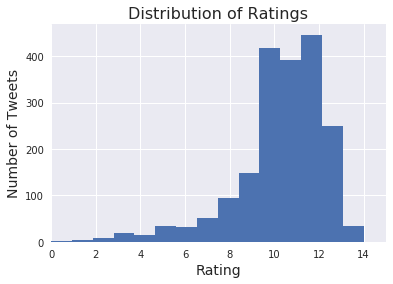

In [5]:
master_data['rating'].hist(bins=15);
plt.xlim(0, 15)
plt.ylabel('Number of Tweets', fontsize = 14)
plt.xlabel('Rating', fontsize = 14)
plt.title('Distribution of Ratings', fontsize = 16)
plt.show();

In [6]:
master_data['rating'].mean()

10.532277634961439

In [7]:
master_data['rating'].mode()

0    12.0
dtype: float64

In [8]:
master_data['rating'].median()

11.0

> - It is clear that rating is left skewed with mean rating as 10.5327.

#### Top 5 Most retweeted tweet

In [9]:
master_data.sort_values('retweet_count',ascending=False)[['tweet_id','rating','retweet_count','favorite_count','breed','name','stage']].head()

,tweet_id,rating,retweet_count,favorite_count,breed,name,stage
759,744234799360020481,13.0,76225,153857,Labrador_retriever,None,doggo
793,739238157791694849,13.0,56678,113769,Eskimo_dog,None,doggo
391,807106840509214720,13.0,55581,118804,Chihuahua,Stephan,none
302,822872901745569793,13.0,42950,131244,Lakeland_terrier,None,puppo
58,879415818425184262,13.0,39929,97976,English_springer,Duddles,none


#### Top 5 Most favorite tweet

In [10]:
master_data.sort_values('favorite_count',ascending=False)[['tweet_id','rating','retweet_count','favorite_count','breed','name','stage']].head()

,tweet_id,rating,retweet_count,favorite_count,breed,name,stage
759,744234799360020481,13.0,76225,153857,Labrador_retriever,None,doggo
302,822872901745569793,13.0,42950,131244,Lakeland_terrier,None,puppo
391,807106840509214720,13.0,55581,118804,Chihuahua,Stephan,none
107,866450705531457537,13.0,32368,114917,French_bulldog,Jamesy,pupper
793,739238157791694849,13.0,56678,113769,Eskimo_dog,None,doggo


#### What is the most common stage?

In [11]:
stage=master_data.groupby('stage').tweet_id.count()

In [12]:
stage=(stage/stage.sum())*100

In [13]:
stage

stage
doggo      3.598972 
floofer    0.411311 
none       84.473008
pupper     10.334190
puppo      1.182519 
Name: tweet_id, dtype: float64

In [14]:
with_stage_sum = sum(master_data.stage != 'none')
tweets_with_stage = round(with_stage_sum * 100 / master_data.shape[0])
print("Number of tweets WITH stage:  {}".format(with_stage_sum))
print("Percentage of tweets:          {}%".format(round(tweets_with_stage, 3)))

Number of tweets WITH stage:  302
Percentage of tweets:          16%


> Only a small proportion of tweets with dog stages identified.

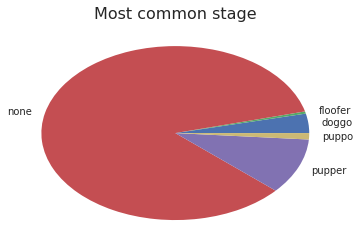

In [15]:
plt.pie(stage,labels=stage.index)
plt.title('Most common stage', fontsize = 16);

#### What are the 10 most common breeds of dogs tweeted about? (Excluding the category 'none'.)

In [16]:
str = "Number of tweets with 'none' predicted breed:  {} ({}%)"
none_count = sum(master_data.breed == 'none')
none_perc = none_count * 100 / master_data.shape[0]
print(str.format(none_count, round(none_perc)))

str = "Number of distinct breeds:  {}"
print(str.format(len(master_data.breed.unique())))


Number of tweets with 'none' predicted breed:  302 (16%)
Number of distinct breeds:  114


In [17]:
top10_breeds_count = \
master_data[master_data.breed != 'none'].breed.value_counts().head(10)
print("Breed and number of tweets")
print("--------------------------")
print(top10_breeds_count)

top10_per = round(sum(top10_breeds_count) * 100 / master_data.shape[0])
print("\nTop 10 dog breeds make up {}% of all tweets".format(top10_per))

Breed and number of tweets
--------------------------
golden_retriever      153
Labrador_retriever    101
Pembroke              94 
Chihuahua             89 
pug                   62 
toy_poodle            49 
chow                  47 
Samoyed               41 
Pomeranian            41 
malamute              33 
Name: breed, dtype: int64

Top 10 dog breeds make up 37% of all tweets


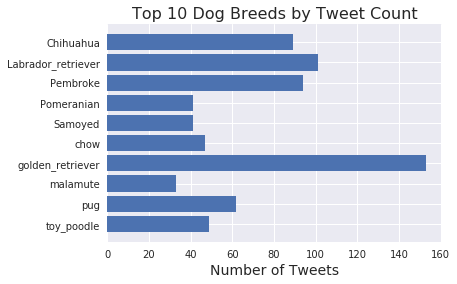

In [18]:
plt.barh(top10_breeds_count.index, top10_breeds_count)

plt.xlabel('Number of Tweets', fontsize = 14)
# plt.ylabel('Dog Breed', fontsize = 14)
plt.title('Top 10 Dog Breeds by Tweet Count', fontsize = 16)
plt.gca().invert_yaxis()
plt.show();

The bar chart above shows that the most common dog that is tweeted about, with almost 160 tweets, is the Golden Retriever, as identified (predicted) by the neural network. Labrador Retrievers, Pembrokes and Chihuahuas are fairly close together in 2nd, 3rd, and 4th place. Further down we'll take a look at what are the most favourited dog breeds.

### Bivariate Analysis

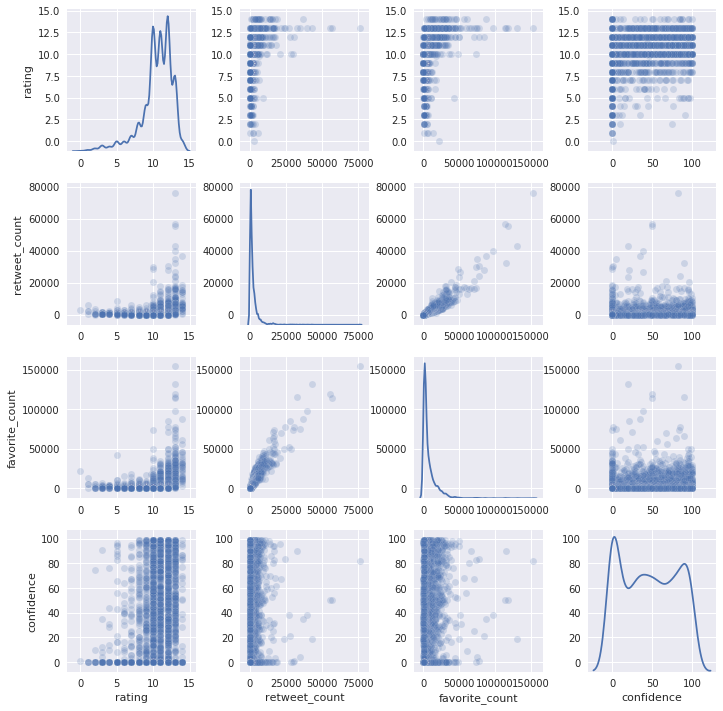

In [19]:
sns.pairplot(master_data, 
             vars = ['rating', 'retweet_count', 'favorite_count', 'confidence'], 
             diag_kind = 'kde', plot_kws = {'alpha': 0.2});

> It clear that there is positive relation between `retweet_count` and `favorite_count`

#### How are ratings distributed within each of the dog breeds with highest favourite counts?

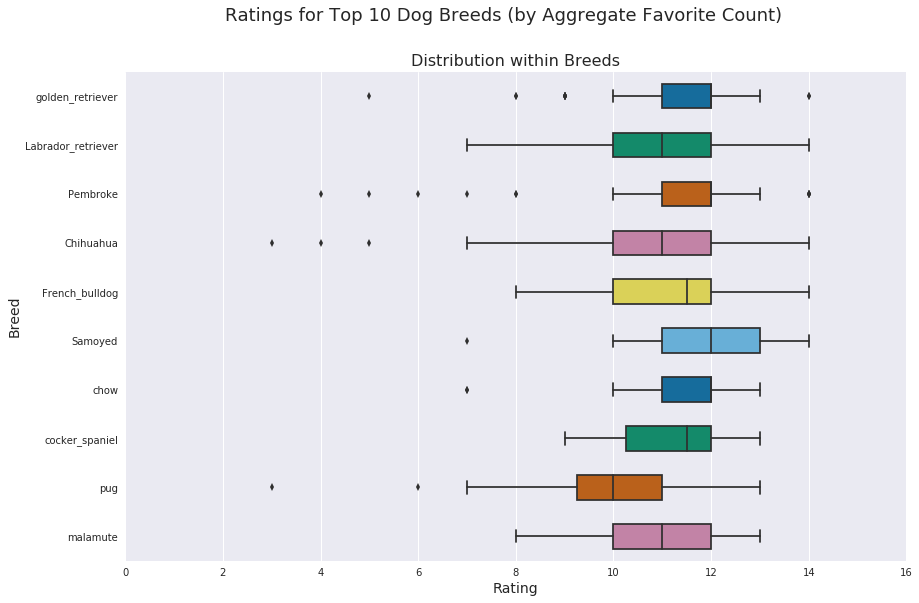

In [28]:
plt.figure(figsize = (14, 9))
bplot = sns.boxplot(y = 'breed', x = 'rating',
                    data = master_data,
                    orient = 'h',
                    width = 0.5,
                    palette = "colorblind",
                    order = top10_breeds_fav_counts.index.tolist())
plt.xlim(0, 16)

# title and labels
plt.suptitle('Ratings for Top 10 Dog Breeds (by Aggregate Favorite Count)', fontsize = 18)
plt.title('Distribution within Breeds', fontsize = 16)
plt.ylabel("Breed",  fontsize = 14)
plt.xlabel('Rating',  fontsize = 14)
# plt.yticks(rotation = 60,  fontsize = 12)
plt.show()
plt.savefig('boxplot')

The boxplot here shows the distribution of ratings within each of the top 10 dog breeds as ranked by aggregate favourite count. All the breeds range between 7 and 13, with a only a few outliers, while four of the breeds have the lower ratings at 10. Another four breeds have the highest ratings at 14.

#### What dog breeds have the highest overall favourite counts?

In [23]:
fav_counts_breed = master_data[master_data.breed != 'none']
fav_counts_breed = fav_counts_breed.groupby(['breed'])
fav_counts_breed = fav_counts_breed['favorite_count'].sum()
fav_counts_breed = fav_counts_breed.sort_values(ascending = False)
top10_breeds_fav_counts = fav_counts_breed.head(10)
top10_breeds_fav_counts

breed
golden_retriever      1736818
Labrador_retriever    1095746
Pembroke              956577 
Chihuahua             671242 
French_bulldog        555534 
Samoyed               509352 
chow                  409528 
cocker_spaniel        373492 
pug                   344862 
malamute              322549 
Name: favorite_count, dtype: int64

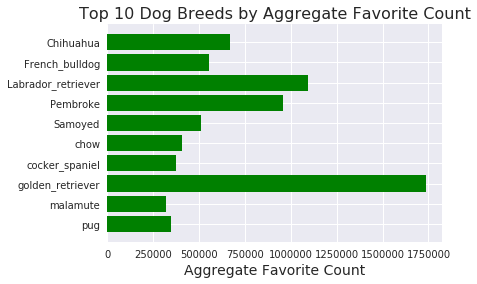

In [24]:
plt.barh(top10_breeds_fav_counts.index, top10_breeds_fav_counts, color = 'g')

plt.xlabel('Aggregate Favorite Count', fontsize = 14)
# plt.ylabel('Dog Breed', fontsize = 12)
plt.title('Top 10 Dog Breeds by Aggregate Favorite Count', fontsize = 16)
plt.gca().invert_yaxis()
plt.show();

The plot above shows the top 10 dog breeds ranked by aggregate favourite counts. It looks very similar to the barplot ealier of top 10 dog breeds ranked by tweet, and in fact the top 4 dog breeds are the same. This also makes sense, as these dogs have the highest number of tweets.

Both groups have these 8 dog breeds in common:

In [25]:
list(set(top10_breeds_count.index) & set(top10_breeds_fav_counts.index))

['Chihuahua',
 'chow',
 'golden_retriever',
 'Samoyed',
 'Labrador_retriever',
 'pug',
 'malamute',
 'Pembroke']

In [26]:
# time range for tweets
master_data.timestamp.min(), master_data.timestamp.max()

('2015-11-15 22:32:08', '2017-08-01 16:23:56')